In [1]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import pandas as pd
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits 
from scipy import stats

# Get Galaxy Data 

In [2]:

query = "select top 50000 z, ra, dec, bestObjID from specObj where class = 'galaxy' and z > 0.1 and zWarning = 0"
galaxy_data = SDSS.query_sql(query)

gal_ra = galaxy_data['ra']
gal_dec = galaxy_data['dec']
galcoords = {'ra': gal_ra, 'dec': gal_dec}
galcoords = pd.DataFrame(galcoords)




### Make subsections of sky in terms of RA and Dec, and count the number of galaxies in each subsection

In [3]:
#bins of ra and decs 
ra_ranges = np.linspace(0, 360, num=100)  
dec_ranges = np.linspace(-90, 90, num=100)  

# Create bins for RA and Dec
galcoords['RA_bin'] = pd.cut(galcoords['ra'], bins=ra_ranges, labels=False)
galcoords['Dec_bin'] = pd.cut(galcoords['dec'], bins=dec_ranges, labels=False)

# Group by RA and Dec bins and count the number of galaxies in each bin
galaxy_counts = galcoords.groupby(['RA_bin', 'Dec_bin']).size().reset_index(name='GalaxyCount')

galaxy_densities = galaxy_counts['GalaxyCount'].values



## Fitting Exponential Decay Curve 

[0.04691752 0.04604627]


/var/folders/10/9g_v7hwd5jb439c_lf1wpw9r0000gn/T/ipykernel_67543/3159895348.py:9: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)


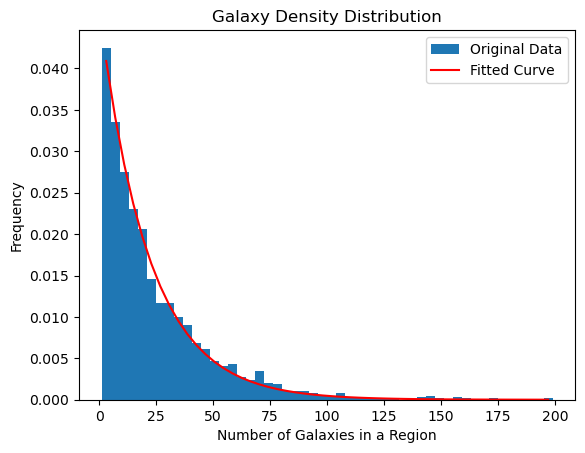

In [4]:
from scipy.optimize import curve_fit
hist_y, bin_edges, _ = plt.hist(galaxy_densities, bins=50, density=True, label='Original Data')

# Calculate bin centers (x values)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


def exp_decay(x, a, b):
    return a * np.exp(-b * x)

#Fit the curve to the data
popt, pcov = curve_fit(exp_decay, bin_centers, hist_y)


a_opt, b_opt = popt

# Generate the fitted curve
y_fit = exp_decay(bin_centers, a_opt, b_opt)

# Plot the original data and the fitted curve

plt.plot(bin_centers, y_fit, 'r-', label='Fitted Curve')
plt.title('Galaxy Density Distribution')
plt.xlabel('Number of Galaxies in a Region')
plt.ylabel('Frequency')
plt.legend();
print(popt)

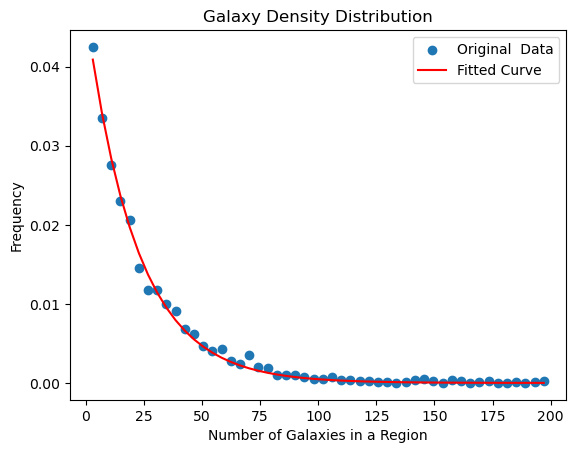

In [5]:
plt.scatter(bin_centers, hist_y, label='Original  Data')
plt.plot(bin_centers, y_fit, 'r-', label='Fitted Curve')
plt.title('Galaxy Density Distribution')
plt.xlabel('Number of Galaxies in a Region')
plt.ylabel('Frequency')
plt.legend();

# CMB Data 

### 1. Read in and plot 

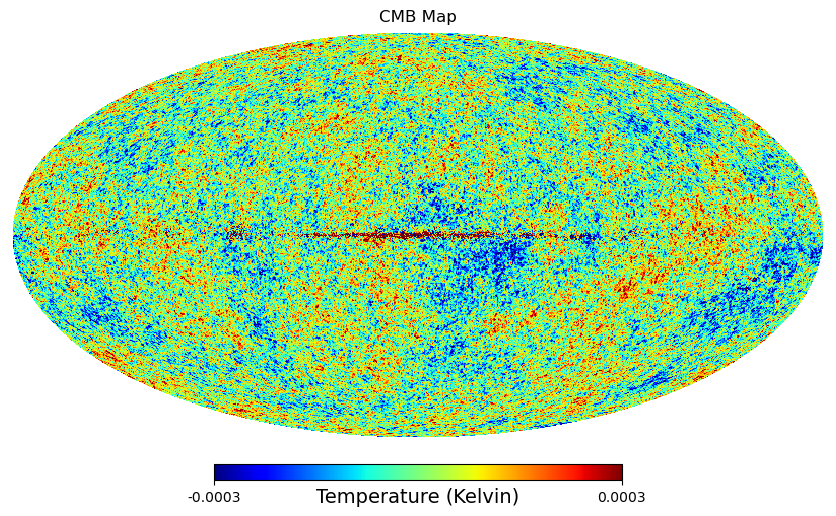

In [6]:
#                              Its a big file 
cmb_map, header = hp.read_map('Bigboy.fits', h=True, field=0, dtype=np.float64)
nside=2048
# Plot the Healpix map

hp.mollview(cmb_map, title='CMB Map', unit='Temperature (Kelvin)', cmap='jet', min=-0.0003, max=0.0003)
plt.show()


## 2. Convert pixels to RA and Dec coordinates, separate values into subsections, just like with the galaxies. 
#### A value will be assigned to each bin, and will be the average temperature of the CMB in that RA/Dec range


In [7]:
# Get the pixel coordinates (theta, phi) for all pixels in the map
theta, phi = hp.pix2ang(nside, np.arange(len(cmb_map)))

# Convert phi and theta to RA and Dec in degrees
ra = np.degrees(phi)
dec = np.degrees(np.pi / 2 - theta)

# Create a DataFrame with RA, Dec, and Temperature values
cmb_df = pd.DataFrame({'RA': ra, 'Dec': dec, 'Temperature': cmb_map})

# Define RA and Dec ranges and the number of bins
ra_ranges = np.linspace(0, 360, num=100)  
dec_ranges = np.linspace(-90, 90, num=100)  

# Create bins for RA and Dec for CMB map
cmb_df['RA_bin'] = pd.cut(cmb_df['RA'], bins=ra_ranges, labels=False)
cmb_df['Dec_bin'] = pd.cut(cmb_df['Dec'], bins=dec_ranges, labels=False)

# Group by RA and Dec bins and calculate the average temperature in each bin
cmb_bin_means = cmb_df.groupby(['RA_bin', 'Dec_bin']).agg({'Temperature': 'mean'}).reset_index()
merged_df = pd.merge(galaxy_counts, cmb_bin_means, on=['RA_bin', 'Dec_bin'], how='inner')


In [8]:
merged_df

,RA_bin,Dec_bin,GalaxyCount,Temperature
0,0,43,67,-0.000039
1,0,44,36,-0.000010
2,0,45,5,0.000033
3,0,46,9,0.000053
4,0,47,14,0.000051
...,...,...,...,...
2003,98,65,4,-0.000026
2004,98,66,1,-0.000034
2005,98,67,4,-0.000039
2006,98,68,2,0.000026


# Statistics on the CMB Data

6.361865073840527e-05

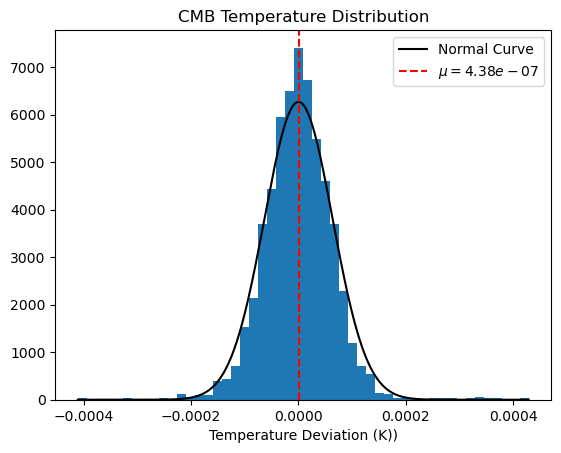

In [9]:
cmb_temps = merged_df['Temperature']
galcounts = merged_df['GalaxyCount']

cmb_mean = np.mean(cmb_temps)
cmb_std = np.std(cmb_temps)
plt.hist(cmb_temps, bins=50, density=True)

x = np.linspace(min(merged_df['Temperature']), max(merged_df['Temperature']), 1000)
normal_distribution = stats.norm.pdf(x, cmb_mean, cmb_std)

plt.plot(x, normal_distribution, label='Normal Curve', c='black')
plt.xlabel('Temperature Deviation (K))')
plt.title('CMB Temperature Distribution')
plt.axvline(cmb_mean, c='red', label=f'$\mu= {cmb_mean:.3}$', linestyle='--')
plt.legend()
cmb_std

In [10]:
stat, p_value = stats.kstest(cmb_temps, 'norm')
stat, p_value 


(0.49983612558493046, 0.0)

### T-test

In [11]:
hypothetical_mean = 0.0
t_statistic, p_value = stats.ttest_1samp(cmb_temps, hypothetical_mean)
t_statistic, p_value

(0.30837962145646736, 0.7578254896982451)

# Combined Analysis

Text(0.5, 0, 'Temperature')

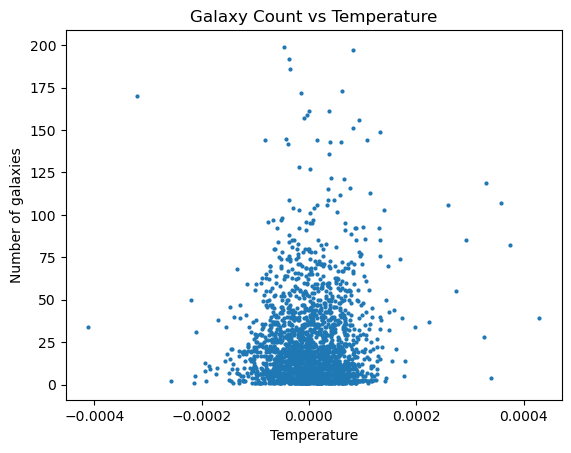

In [12]:

plt.scatter(cmb_temps, galaxy_densities, s=4)
plt.title('Galaxy Count vs Temperature')
plt.ylabel('Number of galaxies')
plt.xlabel('Temperature')



### Correlation coefficient of CMB/galaxy Density 

In [13]:
r, p_value = stats.pearsonr(galcounts, cmb_temps)
r,p_value

(0.09361658265005679, 2.649841715188603e-05)